In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.io import wavfile
from scipy import signal
from scipy.signal import periodogram as periodogram_f
from scipy.fft import fftfreq, fftshift
from scipy.fft import fft, ifft, fft2, ifft2
# No science or notebook style sheet
# plt.style.use(['science', 'notebook'])

Note: The treatment below considers a deterministic realization of $X_t$ (as opposed to treating it like a random variable)

# The Power Spectrum

All time series are technically continuous functions $X(t)$. There's a theorem that says any $X(t)$ can be represented by an infinite linear combination of complex exponentials

$$X(t) = \int_{-\infty}^{\infty} e^{i 2 \pi f t} A(f) df$$

When a time series is measured it is discrete and given by $X(t_k)$ where $t_k = k \Delta t$ and $k$ is some integer. If the time series is band limited to $-1/(2\Delta t) < f < 1/(2\Delta t)$ then $X(t_k)$ can be expressed as

$$X(t_k) = \int_{-1/(2\Delta t)}^{1/(2\Delta t)} e^{i 2 \pi f t_k} A(f) df$$

where $1/(2\Delta t)$ is the **nyquist frequency** and 

$$\boxed{|A(f)|^2 \equiv S(f)}$$

$S(f)$ is known as the **power spectrum**. It measures the *power* or *amplitude* of a certain frequency present in the continuous time series $X(t)$. If $X(t)$ is real, then $S(f)=S(-f)$, so we only need to consider positive frequencies.


### Note on Nyquist Frequency

If the signal is not band limited to $-1/(2\Delta t) < f < 1/(2\Delta t)$ then $X(t_k)$ can be written as

$$X(t_k) = \int_{-1/(2\Delta t)}^{1/(2\Delta t)} e^{i 2 \pi f t_k} A'(f) df$$

where

$$A'(f) = \sum_{k=-\infty}^{\infty} A(f + k/\Delta t) $$

Thus $S'(f) = |A'(f)|^2 \neq S(f)$ and we get power at higher frequencies showing up at lower frequencies. This is known as **aliasing**.

**Example**:

In [20]:
f = np.linspace(-2.5, 2.5, 1000)
A = np.zeros(1000)
A[(f>-1.85)*(f<-1.8)] = 1
A[(f>-1)*(f<-0.95)] = 1/3
A[(f>-0.3)*(f<-0.2)] = 0.5
A[(f>0.1)*(f<0.2)] = 1.4
A[(f>1.5)*(f<1.6)] = 0.2

Plot sample $A(f)$

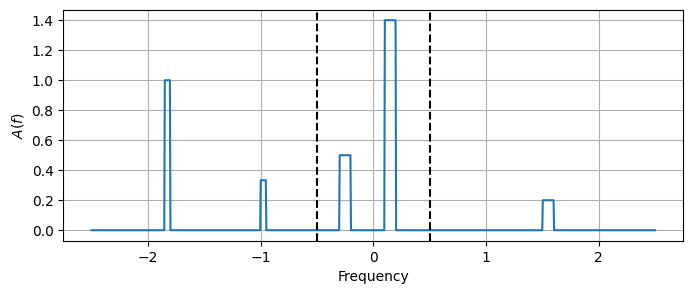

In [21]:
plt.figure(figsize=(8,3))
plt.plot(f,A)
plt.axvline(-0.5, color='k', ls='--')
plt.axvline(0.5, color='k', ls='--')
plt.xlabel('Frequency')
plt.ylabel('$A(f)$')
plt.grid()
plt.show()

Simulate what $A'(f)$ would look like

In [22]:
A_prime = np.stack([sum(np.split(A, [200,400,600,800]))]*5).ravel()

Plot

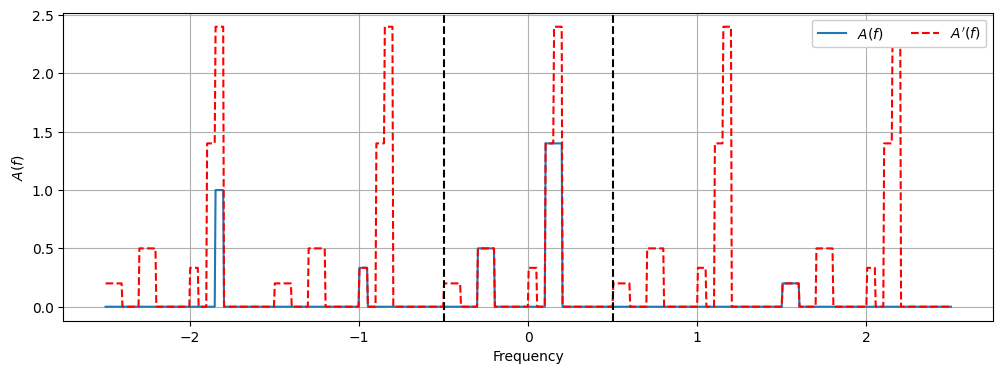

In [23]:
plt.figure(figsize=(12,4))
plt.plot(f,A, label='$A(f)$')
plt.plot(f,A_prime, color='r', ls='--', label="$A'(f)$")
plt.axvline(-0.5, color='k', ls='--')
plt.axvline(0.5, color='k', ls='--')
plt.xlabel('Frequency')
plt.ylabel('$A(f)$')
plt.legend(ncol=3, fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.grid()
plt.show()

## Estimating Power Spectrum

There are various ways to estimate the power spectrum of $X(t)$, these estimators are denoted $\hat{S}$ (hat usually means estimator in statistics). They are estimated by doing operations on $X_t$

$$\mathcal{O}(X_t) \to \hat{S}$$

### The Periodogram

The simplest estimator. Given by

$$\boxed{\hat{S}^{(p)}(f) = \frac{\Delta t \left|\text{DFT}[X(t_k)](f)\right|^2}{N}}$$

where $DFT$ is the discrete Fourier transform. Easy to compute, but the issue is that it doesnt give the *true* power spectrum at all frequencies. Can be shown that

$$\hat{S}^{(p)}(f) = S(f) \otimes \frac{\Delta t \sin^2(N\pi f \Delta t)}{N\sin^2 (\pi f \Delta t)}$$

However, at certain frequencies known as the fourier frequencies $f_n = n/(N \Delta t)$, the convolution term approaches a delta function, and the bias is removed (collect more and more points with the same sampling frequency $\Delta t$ will remove the bias). In that sense, the periodogram is unbiased at the Fourier frequencies.

* Thankfully, the DFT function of python only returns the the transform at these given frequencies, so we don't need to worry.

# Guitar Stuff

Read in the recorded note and get an array of times

In [26]:
rate, data = sp.io.wavfile.read('./data/guitar_notes.wav')
data=data[:,0]
time = np.arange(0, len(data), 1)/rate

Define the cutoffs, which seperate the notes

In [27]:
cutoffs = np.array([4.55, 6.3, 9.65, 12.3, 12.8, 14.9,
                    18.3, 19.8, 21.5, 23.7, 24.25, 27,
                    27.85, 30, 36.2, 39, 40.5, 43])*1e5
cutoffs = cutoffs.astype(int)

Plot the notes with the cutoffs

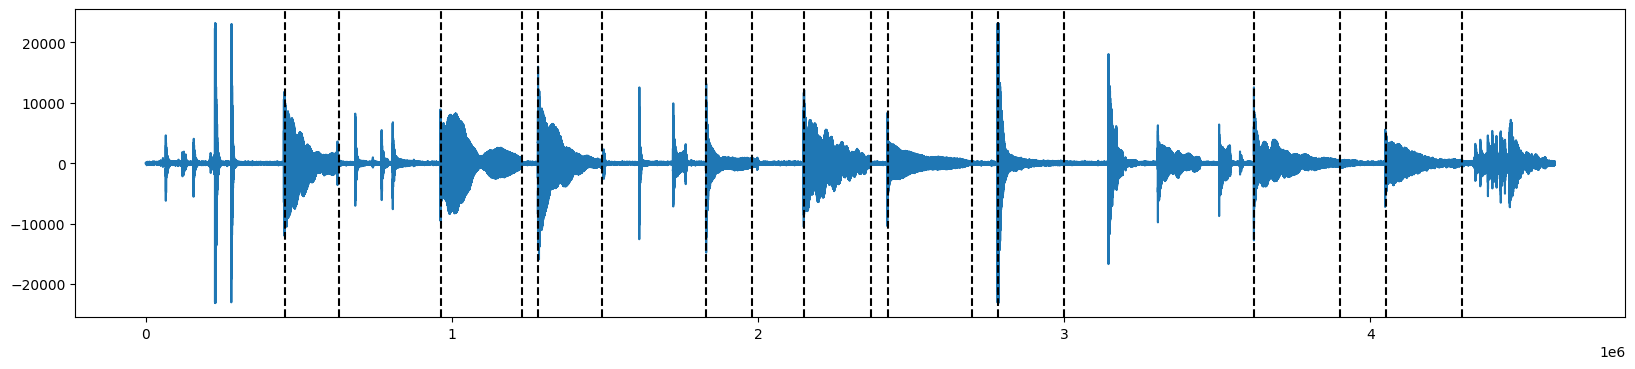

In [28]:
plt.figure(figsize=(20,4))
plt.plot(data)
[plt.axvline(cutoff, color='k', ls='--') for cutoff in cutoffs]
plt.show()

Define the note names, and place notes in their seperate arrays:

In [29]:
note_names = ['E', 'E_mute', 'A', 'A_mute', 'D', 'D_mute', 'G', 'B', 'E_h']
notes = [data[c1:c2] for (c1, c2) in zip(cutoffs[::2], cutoffs[1::2])]
note_dict = dict(zip(note_names, notes))

Plot the waveforms of all the notes

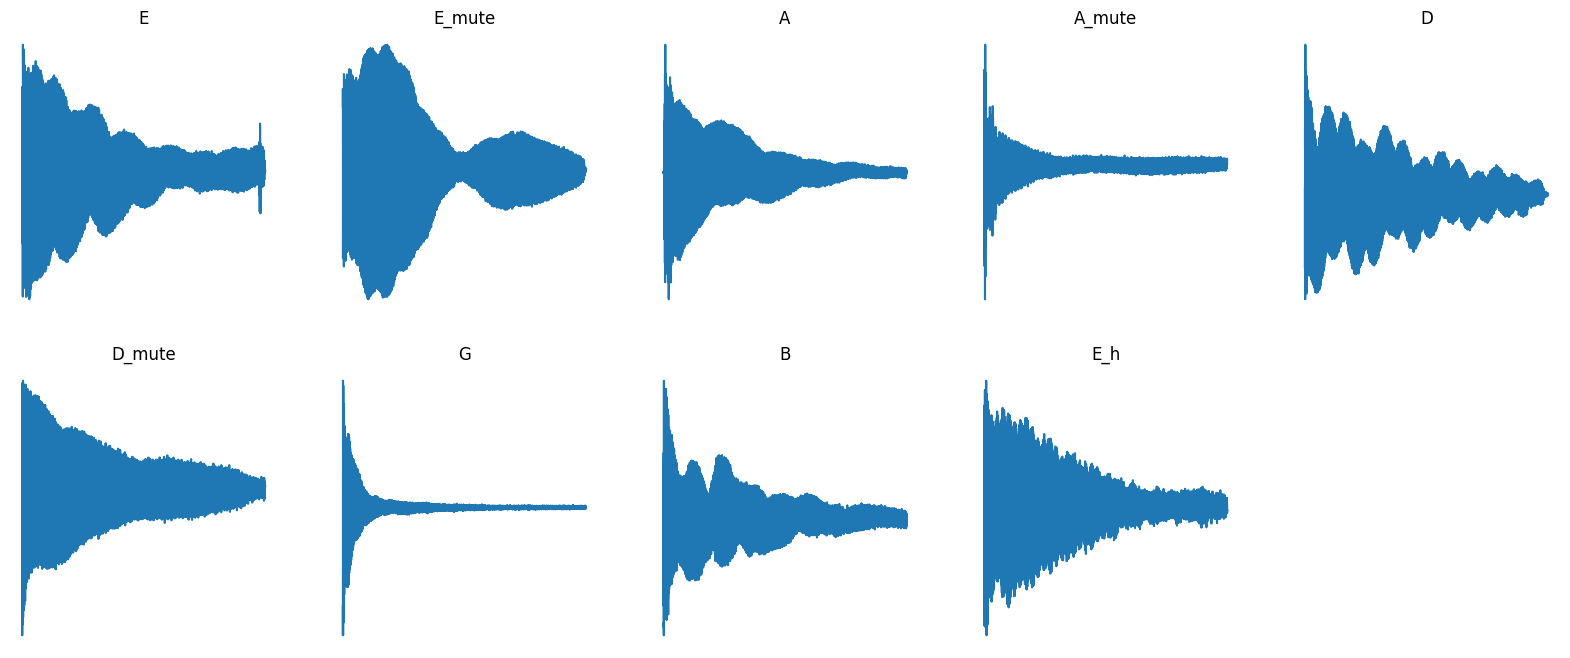

In [30]:
fig, ax = plt.subplots(2,5,figsize=(20,8))
for i in range(len(notes)):
    a = ax.ravel()[i]
    a.plot(note_dict[note_names[i]])
    a.set_title(note_names[i])
[a.set_axis_off() for a in ax.ravel()]
plt.show()

Compute the power spectrum estimator known as the periodogram

$$\hat{S}^{(p)}(f) = \frac{\Delta t \left|\text{FT}[X_t](f)\right|^2}{N}$$

In [31]:
periodogram = np.abs(fft(note_dict['E']))**2 / (rate * len(note_dict['E']))
frequencies = fftfreq(len(note_dict['E']), d=1/rate)
E_fund = 81.2

In [32]:
frequencies


array([ 0.        ,  0.27428571,  0.54857143, ..., -0.82285714,
       -0.54857143, -0.27428571])

Plot periodogram and the harmonics $f_n = nf_1$ for 10 values of $n$ 

* these are the harmonics for waves on a string where $f_1$ is the fundamental frequency (in this case frequency of low E)

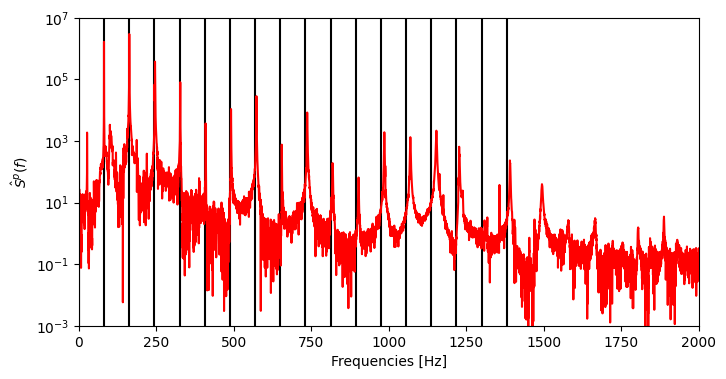

In [33]:
plt.figure(figsize=(8,4))
[plt.axvline(E_fund*i, color='k') for i in range(18)]
plt.plot(fftshift(frequencies), fftshift(periodogram), color='r')
plt.xlim(0,2000)
plt.ylim(bottom=1e-3, top=1e7)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('$\hat{S}^{p}(f)$')
plt.semilogy()
plt.show()

Can also use scipy's periodogram function

In [34]:
frequencies, periodogram = periodogram_f(note_dict['E'], fs=rate)

Plot

[]

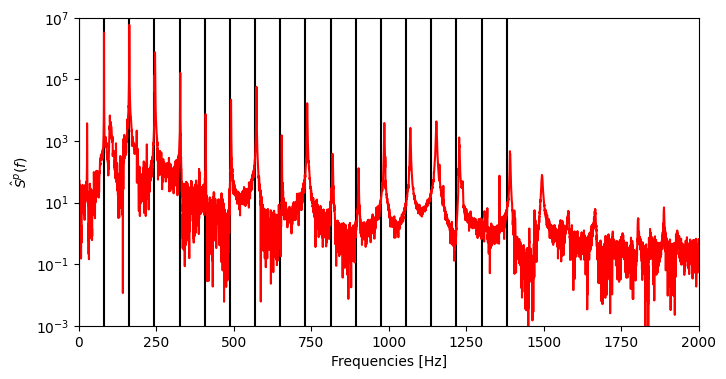

In [35]:
plt.figure(figsize=(8,4))
[plt.axvline(E_fund*i, color='k') for i in range(18)]
plt.plot(fftshift(frequencies), fftshift(periodogram), color='r')
plt.xlim(0,2000)
plt.ylim(bottom=1e-3, top=1e7)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('$\hat{S}^{p}(f)$')
plt.semilogy()

Now we'll look at "E muted"

* In this case I have rested my finger on the **middle of the string**. Since for the odd harmonics, the middle corresponds to an antinode (moves up and down), placing my finger on it stops it from vibrating up and down. Thus I only get the harmonics where the middle is a node.

* The diagram below corresponds to an even harmonic, so placing my finger in the middle still allows the mode top vibrate

<p align="center">
  <img src="images/node.png" alt="drawing" width="300" align="center"/>
</p>

For now on, the variable `P` will refer to *periodogram* and `f` will refer to the `frequencies`.

In [36]:
f, P = periodogram_f(note_dict['E_mute'], fs=rate)

Plot

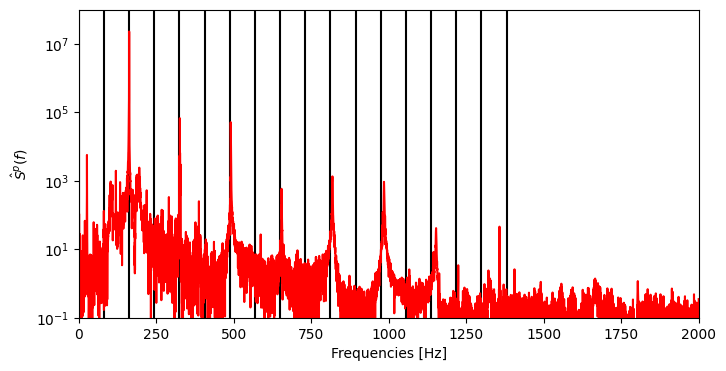

In [37]:
plt.figure(figsize=(8,4))
[plt.axvline(E_fund*i, color='k') for i in range(18)]
plt.plot(f, P, color='r')
plt.xlim(0,2000)
plt.ylim(bottom=1e-1, top=1e8)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('$\hat{S}^{p}(f)$')
plt.semilogy()
plt.show()

As you can see, the odd harmonics are removed

Sometimes it makes sense to smooth a spectrum using a convolution (for smooth spectra). In this case, however, since we have narrow peaks, it tends to reduce the power at these peaks.

In [38]:
P_smoothed = np.convolve(P, np.ones(5)/5, mode='same')

Plot

[]

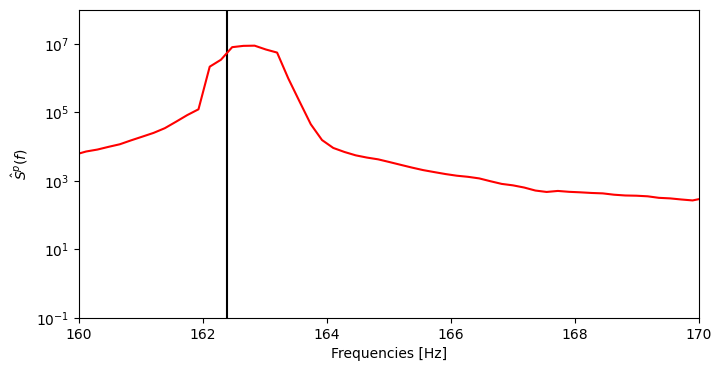

In [39]:
plt.figure(figsize=(8,4))
[plt.axvline(E_fund*i, color='k') for i in range(18)]
plt.plot(f, P_smoothed, color='r')
plt.xlim(0,2000)
plt.xlim(160,170)
plt.ylim(bottom=1e-1, top=1e8)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('$\hat{S}^{p}(f)$')
plt.semilogy()

# Decay of Harmonic Power over Time

While we can consider the periodogram as a whole, it might be more interesting to break the note up into segments and see how the amplitude of the **harmonic frequencies** change with time. For example, do they all decay at the same rate?

In [40]:
def compute_periodograms(ts, n=10):
    T = int(len(ts)/n)
    Ps = []
    time_of_Ps = []
    for i in range(n):
        f, P = periodogram_f(ts[i*T:(i+1)*T], fs=rate)
        time_of_Ps.append((i+0.5)*T/ rate) 
        Ps.append(P)
    
    return np.array(time_of_Ps),Ps,f

This function is used to extract the amplitude of each fourier frequency of a collection of periodograms `Ps` with frequencies `f`

In [41]:
def extract_peaks(Ps, f, harmonic_freqs, eps=1, A=100):
    harmonic_amplitudes = []
    for P in Ps:
        amplitudes = []
        for freq in harmonic_freqs:
            P_range = P[(f>(freq-eps))*(f<(freq+eps))]
            amplitude = sum(P_range[P_range>max(P_range)/A])
            amplitudes.append(amplitude)
        harmonic_amplitudes.append(amplitudes)
    return np.array(harmonic_amplitudes)

Compute a bunch of periodograms as a function of time for the low E on the guitar

In [42]:
time_of_Ps, Ps, f = compute_periodograms(note_dict['E'])

Plot these periodograms

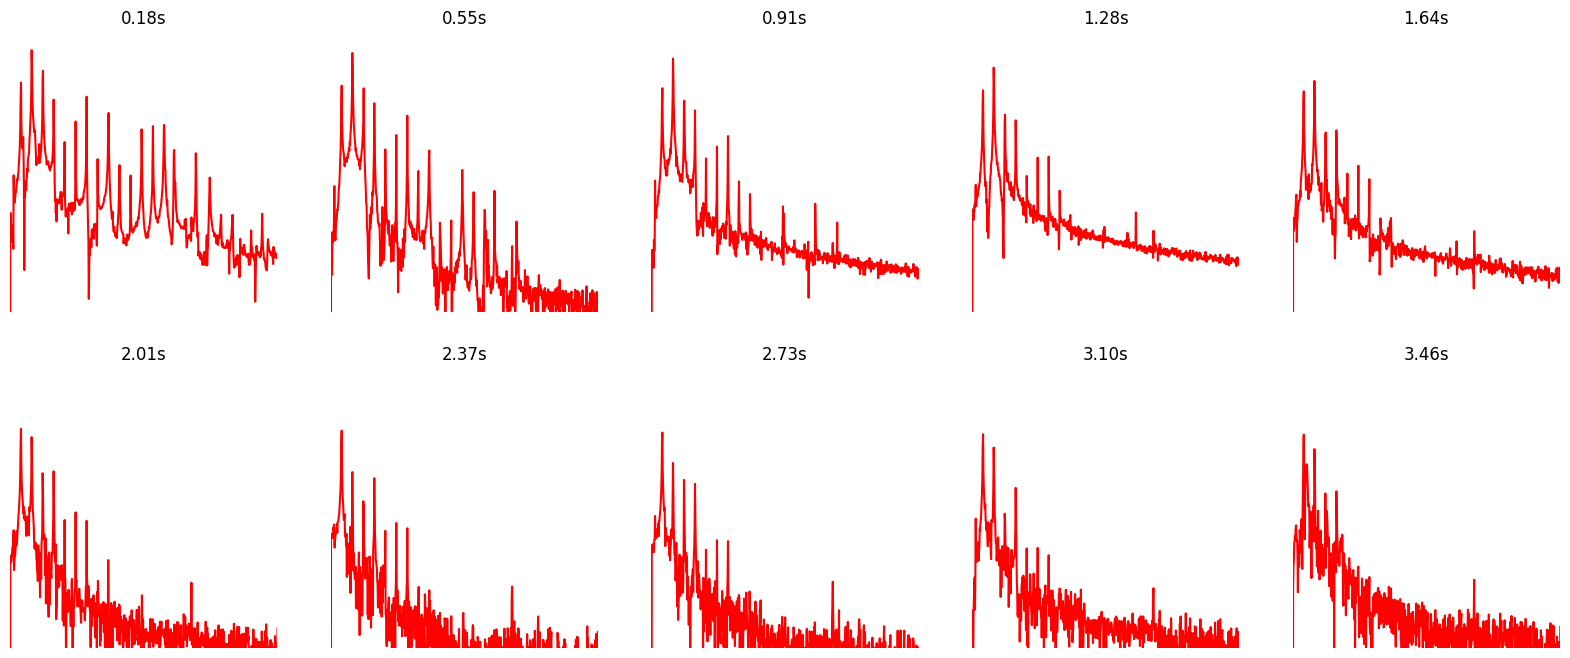

In [43]:
fig, ax = plt.subplots(2,5,figsize=(20,8))
for i, a in enumerate(ax.ravel()):
    a.plot(f, Ps[i], color='r')
    a.set_xlim(0,2000)
    a.set_ylim(bottom=1e-1, top=1e7)
    a.set_title(f'{time_of_Ps[i]:.2f}s')
    a.semilogy()
    a.set_axis_off()
plt.show()

Get the **harmonic amplitudes** as a function of time

In [44]:
harmonic_fundamental = E_fund
time_of_Ps, Ps, f = compute_periodograms(note_dict['E_mute'], n=15)
fourier_amp = extract_peaks(Ps, f, np.arange(1,10)*harmonic_fundamental, eps=8)

Plot these fourier amplitudes

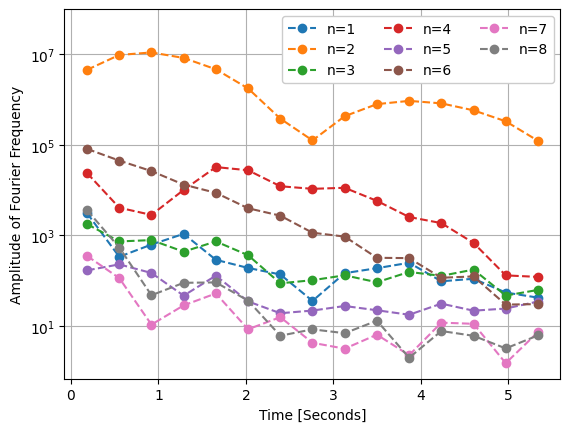

In [45]:
plt.plot(time_of_Ps, fourier_amp[:,0], 'o--', label='n=1')
plt.plot(time_of_Ps, fourier_amp[:,1], 'o--', label='n=2')
plt.plot(time_of_Ps, fourier_amp[:,2], 'o--', label='n=3')
plt.plot(time_of_Ps, fourier_amp[:,3], 'o--', label='n=4')
plt.plot(time_of_Ps, fourier_amp[:,4], 'o--', label='n=5')
plt.plot(time_of_Ps, fourier_amp[:,5], 'o--', label='n=6')
plt.plot(time_of_Ps, fourier_amp[:,6], 'o--', label='n=7')
plt.plot(time_of_Ps, fourier_amp[:,7], 'o--', label='n=8')
plt.xlabel('Time [Seconds]')
plt.ylabel('Amplitude of Fourier Frequency')
plt.grid()
plt.semilogy()
plt.ylim(top=1e8)
plt.legend(ncol=3, fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.show()

# Plucking Different Positions on String

Open up another data set where I plucked the string at different positions along the length

In [48]:
rate, data = sp.io.wavfile.read('./data/guitar_notes2.wav')
data=data[:,0]
time = np.arange(0, len(data), 1)/rate
cutoffs = np.array([1.9, 4, 4.7, 6.6, 9.85, 12])*1e5
cutoffs = cutoffs.astype(int)
note_names = ['E1', 'E2', 'E3']
notes = [data[c1:c2] for (c1, c2) in zip(cutoffs[::2], cutoffs[1::2])]
note_dict = dict(zip(note_names, notes))
E_fund = 82

Compute sequences of periodograms for the three positions I plucked on the string

* 1: End of String
* 2: Quarter way along the string
* 3: Half way along the string

In [49]:
time_of_Ps1, Ps1, f1 = compute_periodograms(note_dict['E1'], n=15)
time_of_Ps2, Ps2, f2 = compute_periodograms(note_dict['E2'], n=15)
time_of_Ps3, Ps3, f3 = compute_periodograms(note_dict['E3'], n=15)

Normalize the periodograms so I can compare them with eachother (in case I plucked one note louder than another). I normalized by the magnitude of the first periodogram in case decays are different

In [50]:
Ps1 = [P/Ps1[0].sum() for P in Ps1]
Ps2 = [P/Ps2[0].sum() for P in Ps2]
Ps3 = [P/Ps3[0].sum() for P in Ps3]

Compute the magnitude of the Fourier amplitudes at all the peaks

In [51]:
fourier_amp1 = extract_peaks(Ps1, f1, np.arange(1,11)*harmonic_fundamental, eps=8, A=50)
fourier_amp2 = extract_peaks(Ps2, f2, np.arange(1,11)*harmonic_fundamental, eps=8, A=50)
fourier_amp3 = extract_peaks(Ps3, f3, np.arange(1,11)*harmonic_fundamental, eps=8, A=50)

Plot

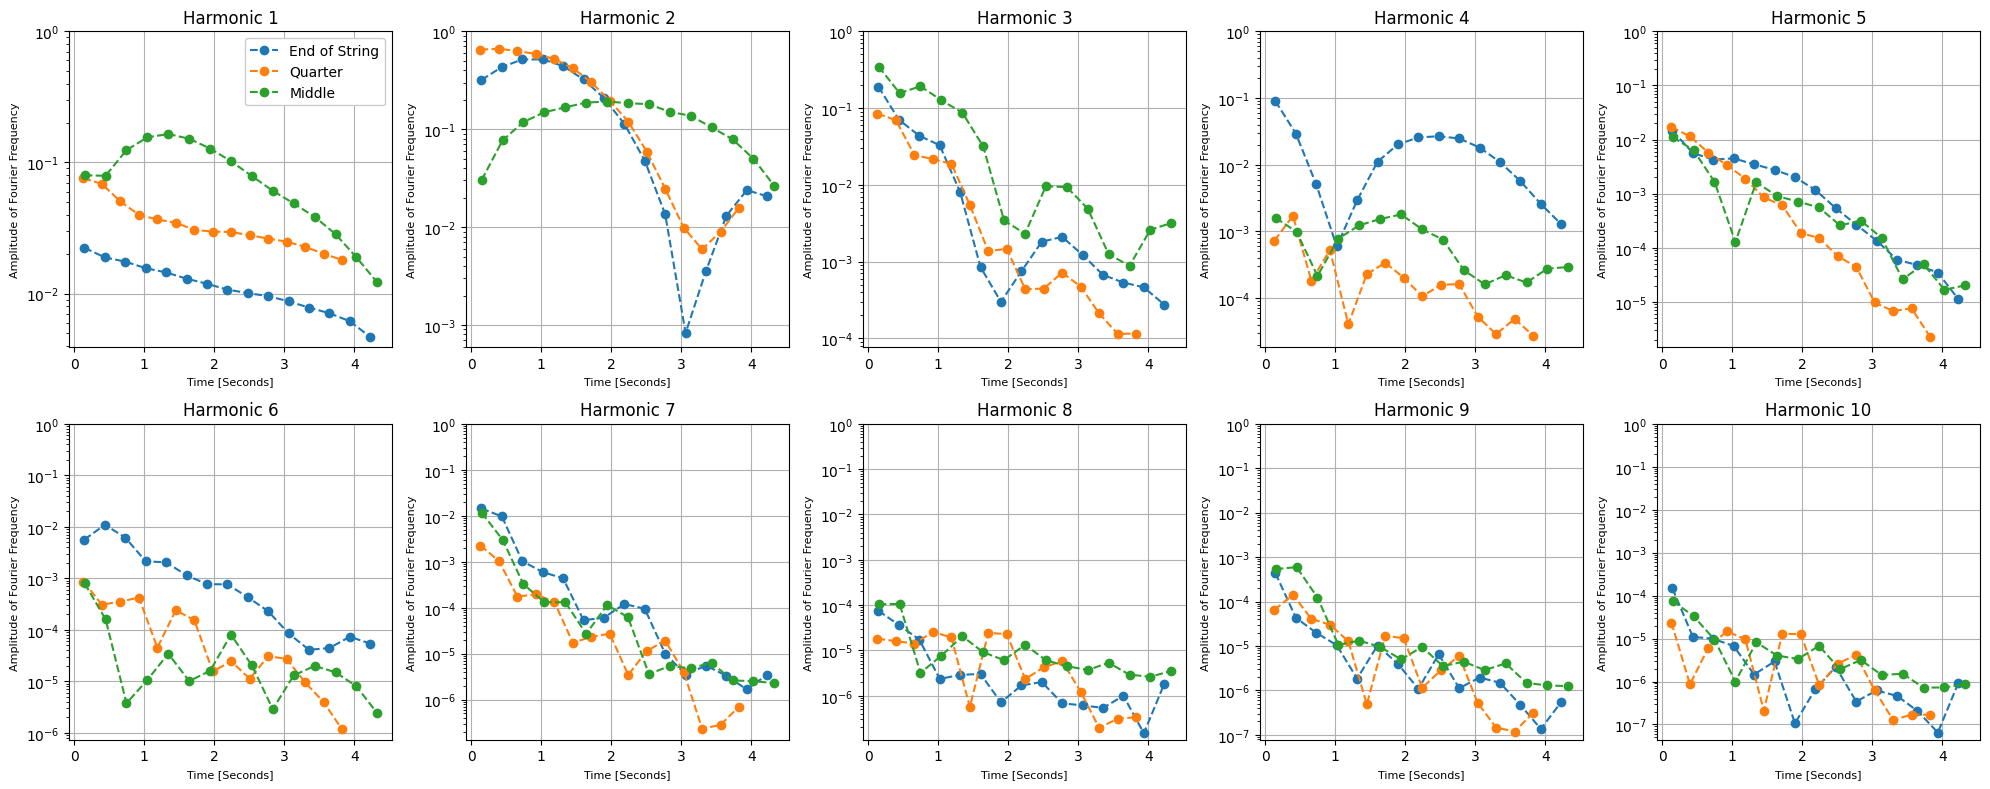

In [52]:
fig, ax = plt.subplots(2,5,figsize=(20,8))
for i, a in enumerate(ax.ravel()):
    a.plot(time_of_Ps1, fourier_amp1[:,i], 'o--', label='End of String')
    a.plot(time_of_Ps2, fourier_amp2[:,i], 'o--', label='Quarter')
    a.plot(time_of_Ps3, fourier_amp3[:,i], 'o--', label='Middle')
    a.set_xlabel('Time [Seconds]', fontsize=8)
    a.set_ylabel('Amplitude of Fourier Frequency', fontsize=8)
    a.grid()
    a.semilogy()
    a.set_ylim(top=1)
    a.set_title(f'Harmonic {i+1}')
    if i==0:
        a.legend(fontsize=10, facecolor='white', framealpha=1, frameon=True)
fig.tight_layout()